**Importing Libraries**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from xgboost import XGBRegressor
from sklearn.metrics import r2_score

**Reading the data**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
train = pd.read_csv('/content/gdrive/MyDrive/wind_train.csv')

In [ ]:
test = pd.read_csv('/content/gdrive/MyDrive/wind_test.csv')

**Preprocessing the train dataset**

In [ ]:
train.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
0,WM_33725,8/4/2019 14:33,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.96190,26.897875,NaN,239.836388,2730.310605,42.084666,BA,Medium,2.217542,0.314065,24.281689,6.766521
1,WM_698,11/5/2018 10:13,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.90408,39.801469,NaN,337.944723,1780.207200,107.888643,A2,Medium,4.210346,0.448494,27.262139,5.966275
2,WM_39146,9/14/2019 14:03,95.484724,NaN,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.92711,36.116065,45.033197,227.850294,1666.049900,-42.931459,ABC,Medium,2.719475,0.302321,27.366127,2.874342
3,WM_6757,12/25/2018 15:33,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.73234,46.020045,44.827154,492.081520,1964.502895,42.744596,ABC,NaN,4.857385,0.367140,24.287767,14.851089
4,WM_21521,5/4/2019 3:13,10.722890,NaN,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.16900,34.572941,-99.000000,259.274601,1177.516152,13.387289,AAA,Medium,NaN,0.453374,27.971650,3.519074


In [ ]:
train.shape

(28200, 22)

In [ ]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28200 entries, 0 to 28199
Data columns (total 22 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   tracking_id                     28200 non-null  object 
 1   datetime                        28200 non-null  object 
 2   wind_speed(m/s)                 27927 non-null  float64
 3   atmospheric_temperature(°C)     24750 non-null  float64
 4   shaft_temperature(°C)           28198 non-null  float64
 5   blades_angle(°)                 27984 non-null  float64
 6   gearbox_temperature(°C)         28199 non-null  float64
 7   engine_temperature(°C)          28188 non-null  float64
 8   motor_torque(N-m)               28176 non-null  float64
 9   generator_temperature(°C)       28188 non-null  float64
 10  atmospheric_pressure(Pascal)    25493 non-null  float64
 11  area_temperature(°C)            28200 non-null  float64
 12  windmill_body_temperature(°C)   

In [ ]:
train.describe()

,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h)
count,27927.000000,24750.000000,28198.000000,27984.000000,28199.000000,28188.000000,28176.000000,28188.000000,2.549300e+04,28200.000000,25837.000000,23097.000000,28199.000000,27628.000000,23107.000000,28200.000000,27657.000000,27993.000000
mean,69.037071,0.383727,40.085387,-9.654038,41.027755,42.614239,1710.819803,65.027857,5.318506e+04,32.735091,20.799761,306.888883,1575.560011,25.849894,2.254034,0.397249,25.887052,6.130529
std,76.275645,44.278534,27.204430,47.918161,43.663605,6.124546,827.205537,19.816499,1.875036e+05,7.703391,54.356431,134.055900,483.326394,32.423943,11.275602,0.061158,7.773609,2.697520
min,-496.211029,-99.000000,-99.000000,-146.259543,-244.974098,3.167151,500.000000,33.893779,-1.188624e+06,-30.000000,-999.000000,0.000000,-1005.222988,-136.732217,-99.000000,0.200111,-30.295253,0.962305
25%,20.883502,7.948900,41.633238,-1.197652,40.557952,41.911365,870.340239,41.198509,1.679492e+04,27.311644,40.448386,238.627752,1268.134042,13.722808,2.544859,0.347445,24.447658,4.059505
50%,93.302129,16.102410,43.686082,-0.495608,43.221735,43.525297,2031.849540,70.729533,1.819113e+04,32.605195,42.786832,271.427656,1678.238404,32.977192,3.453333,0.398591,25.957739,5.764710
75%,95.268058,23.687285,45.673685,5.495030,45.879425,45.174246,2462.585729,78.945849,1.181133e+05,38.232387,44.494543,404.153517,1829.054007,41.550520,4.357862,0.449354,27.477854,7.947195
max,601.455670,80.217444,169.820455,165.932123,999.000000,50.000000,3000.000000,100.000000,1.272552e+06,55.000000,323.000000,569.966479,4693.481933,236.883264,18.209800,0.499975,78.351335,20.175358


**Handling NaN Values**

In [ ]:
train.isnull().sum()

tracking_id                          0
datetime                             0
wind_speed(m/s)                    273
atmospheric_temperature(°C)       3450
shaft_temperature(°C)                2
blades_angle(°)                    216
gearbox_temperature(°C)              1
engine_temperature(°C)              12
motor_torque(N-m)                   24
generator_temperature(°C)           12
atmospheric_pressure(Pascal)      2707
area_temperature(°C)                 0
windmill_body_temperature(°C)     2363
wind_direction(°)                 5103
resistance(ohm)                      1
rotor_torque(N-m)                  572
turbine_status                    1759
cloud_level                        276
blade_length(m)                   5093
blade_breadth(m)                     0
windmill_height(m)                 543
windmill_generated_power(kW/h)     207
dtype: int64

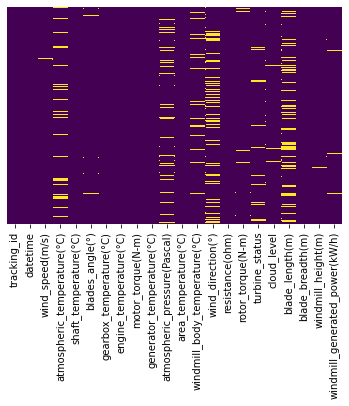

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [ ]:
train =  train.fillna({
    "wind_speed(m/s)" : train["wind_speed(m/s)"].mean(),
    "atmospheric_temperature(°C)" : train["atmospheric_temperature(°C)"].mean(),
    "shaft_temperature(°C)" : train["shaft_temperature(°C)"].mean(),
    "blades_angle(°)" : train["blades_angle(°)"].mean(),
    "gearbox_temperature(°C)" : train["gearbox_temperature(°C)"].mean(),
    "engine_temperature(°C)" : train["engine_temperature(°C)"].mean(),
    "motor_torque(N-m)" : train["motor_torque(N-m)"].mean(),
    "generator_temperature(°C)" : train["generator_temperature(°C)"].mean(),
    "atmospheric_pressure(Pascal)" : train["atmospheric_pressure(Pascal)"].mean(),
    "area_temperature(°C)" : train["area_temperature(°C)"].mean(),
    "windmill_body_temperature(°C)" : train["windmill_body_temperature(°C)"].mean(),
    "wind_direction(°)" : train["wind_direction(°)"].mean(),
    "resistance(ohm)" : train["resistance(ohm)"].mean(),
    "rotor_torque(N-m)" : train["rotor_torque(N-m)"].mean(),
    "blade_length(m)" : train["blade_length(m)"].mean(),
    "blade_breadth(m)" : train["blade_breadth(m)"].mean(),
    "windmill_height(m)" : train["windmill_height(m)"].mean(),
    "windmill_generated_power(kW/h)" : train["windmill_generated_power(kW/h)"].mean()
    })

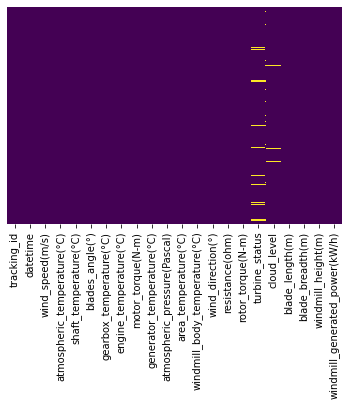

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap="viridis")

**Handling categorial NaN values**

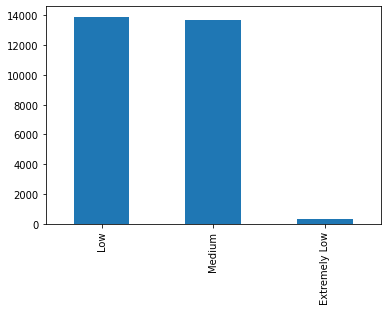

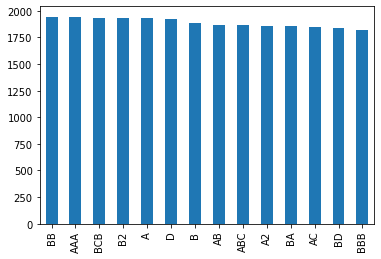

In [ ]:
train["cloud_level"].value_counts().plot.bar()
plt.show()
train["turbine_status"].value_counts().plot.bar()
plt.show()

In [ ]:
train["turbine_status"].mode()

0    BB
dtype: object

In [ ]:
train["cloud_level"].fillna("Low",inplace=True)
train["turbine_status"].fillna("BB",inplace=True)

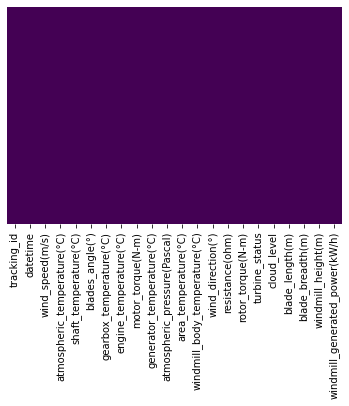

In [ ]:
sns.heatmap(train.isnull(),yticklabels=False,cbar=False,cmap="viridis")

**Feature Engineering**

In [ ]:
train['datetime']= pd.to_datetime(train['datetime'])
train = pd.get_dummies(data=train,columns=["cloud_level","turbine_status"])
train.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium,turbine_status_A,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D
0,WM_33725,2019-08-04 14:33:00,94.820023,-99.000000,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.96190,26.897875,20.799761,239.836388,2730.310605,42.084666,2.217542,0.314065,24.281689,6.766521,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,WM_698,2018-11-05 10:13:00,241.832734,27.764785,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.90408,39.801469,20.799761,337.944723,1780.207200,107.888643,4.210346,0.448494,27.262139,5.966275,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,WM_39146,2019-09-14 14:03:00,95.484724,0.383727,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.92711,36.116065,45.033197,227.850294,1666.049900,-42.931459,2.719475,0.302321,27.366127,2.874342,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,WM_6757,2018-12-25 15:33:00,238.819424,-99.000000,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.73234,46.020045,44.827154,492.081520,1964.502895,42.744596,4.857385,0.367140,24.287767,14.851089,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,WM_21521,2019-05-04 03:13:00,10.722890,0.383727,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.16900,34.572941,-99.000000,259.274601,1177.516152,13.387289,2.254034,0.453374,27.971650,3.519074,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
train.shape

(28200, 37)

**Data Visualization**

In [ ]:
train.dtypes

tracking_id                               object
datetime                          datetime64[ns]
wind_speed(m/s)                          float64
atmospheric_temperature(°C)              float64
shaft_temperature(°C)                    float64
blades_angle(°)                          float64
gearbox_temperature(°C)                  float64
engine_temperature(°C)                   float64
motor_torque(N-m)                        float64
generator_temperature(°C)                float64
atmospheric_pressure(Pascal)             float64
area_temperature(°C)                     float64
windmill_body_temperature(°C)            float64
wind_direction(°)                        float64
resistance(ohm)                          float64
rotor_torque(N-m)                        float64
blade_length(m)                          float64
blade_breadth(m)                         float64
windmill_height(m)                       float64
windmill_generated_power(kW/h)           float64
cloud_level_Extremel

In [ ]:
col = [ 'wind_speed(m/s)','atmospheric_temperature(°C)', 'shaft_temperature(°C)',
       'blades_angle(°)', 'gearbox_temperature(°C)', 'engine_temperature(°C)',
       'motor_torque(N-m)', 'generator_temperature(°C)',
       'atmospheric_pressure(Pascal)', 'area_temperature(°C)',
       'windmill_body_temperature(°C)', 
       'wind_direction(°)', 'resistance(ohm)',
       'rotor_torque(N-m)', 'blade_length(m)',
       'blade_breadth(m)', 'windmill_height(m)']

In [ ]:
for i in col:
    plt.figure(figsize=(8,4))
    sns.scatterplot(data=train, x=i, y='windmill_generated_power(kW/h)')

In [ ]:
train[train.columns[2:]].corr()['windmill_generated_power(kW/h)'][:]

wind_speed(m/s)                   0.062246
atmospheric_temperature(°C)      -0.000941
shaft_temperature(°C)             0.046366
blades_angle(°)                  -0.153607
gearbox_temperature(°C)           0.053017
engine_temperature(°C)            0.271819
motor_torque(N-m)                 0.503155
generator_temperature(°C)         0.390092
atmospheric_pressure(Pascal)     -0.012578
area_temperature(°C)              0.383173
windmill_body_temperature(°C)     0.003054
wind_direction(°)                 0.311539
resistance(ohm)                   0.239190
rotor_torque(N-m)                 0.184737
blade_length(m)                   0.012881
blade_breadth(m)                  0.085642
windmill_height(m)                0.003855
windmill_generated_power(kW/h)    1.000000
cloud_level_Extremely Low        -0.170808
cloud_level_Low                   0.002305
cloud_level_Medium                0.032698
turbine_status_A                  0.015946
turbine_status_A2                 0.005846
turbine_sta

In [ ]:
train.drop(["atmospheric_temperature(°C)"],axis=1,inplace=True)

**Preprocessing the test dataset**

In [ ]:
test.head()

,tracking_id,datetime,wind_speed(m/s),atmospheric_temperature(°C),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),turbine_status,cloud_level,blade_length(m),blade_breadth(m),windmill_height(m)
0,WM_19817,2019-04-17 08:53:20,94.324266,17.641186,89.714193,51.146788,40.460560,39.594734,1073.202715,66.830037,16681.044117,24.004812,43.756693,445.976992,1664.222023,21.912243,BA,Medium,3.185837,0.403965,25.572431
1,WM_18723,2019-03-30 07:43:20,10.088870,13.978119,43.272846,46.516394,40.027788,41.176860,517.436430,37.284163,NaN,29.431813,42.728174,499.595287,1165.111992,-35.050093,A,Medium,3.016603,0.444755,24.371823
2,WM_34552,2019-08-10 11:33:20,347.152090,31.423035,41.076640,26.931602,43.109122,43.439556,1480.716492,70.010762,214812.836175,29.924235,43.256122,245.432231,1667.720491,27.195302,B2,Medium,2.611941,0.387368,27.654677
3,WM_28570,2019-06-26 03:53:20,24.471997,-99.000000,14.375078,66.513953,13.741253,15.577472,887.979475,41.445258,NaN,23.886434,13.501595,NaN,1329.744740,15.245757,BBB,Low,2.866805,0.450478,24.189426
4,WM_36934,2019-08-27 16:43:20,96.997026,33.281836,41.405192,1.843112,121.572907,43.934587,2053.916354,68.007787,16833.546517,35.906889,-99.000000,442.425744,691.408996,34.257024,A,Low,3.549672,0.368355,4.885440


In [ ]:
print(test.shape)
test.info()

**Handling NaN values**

In [ ]:
test.isnull().sum()

In [ ]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap="viridis")

In [ ]:
test =  test.fillna({
    "wind_speed(m/s)" : test["wind_speed(m/s)"].mean(),
    "atmospheric_temperature(°C)" : test["atmospheric_temperature(°C)"].mean(),
    "shaft_temperature(°C)" : test["shaft_temperature(°C)"].mean(),
    "blades_angle(°)" : test["blades_angle(°)"].mean(),
    "gearbox_temperature(°C)" : test["gearbox_temperature(°C)"].mean(),
    "engine_temperature(°C)" : test["engine_temperature(°C)"].mean(),
    "motor_torque(N-m)" : test["motor_torque(N-m)"].mean(),
    "generator_temperature(°C)" : test["generator_temperature(°C)"].mean(),
    "atmospheric_pressure(Pascal)" : test["atmospheric_pressure(Pascal)"].mean(),
    "area_temperature(°C)" : test["area_temperature(°C)"].mean(),
    "windmill_body_temperature(°C)" : train["windmill_body_temperature(°C)"].mean(),
    "wind_direction(°)" : test["wind_direction(°)"].mean(),
    "rotor_torque(N-m)" : test["rotor_torque(N-m)"].mean(),
    "blade_length(m)" : test["blade_length(m)"].mean(),
    "windmill_height(m)" : test["windmill_height(m)"].mean(),
    })

In [ ]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap="viridis")

**Handling categorial NaN values**

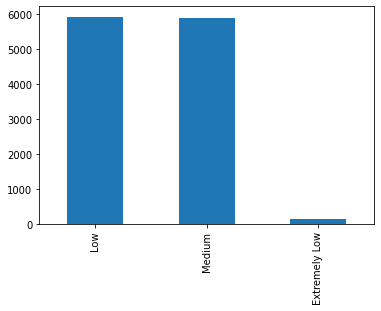

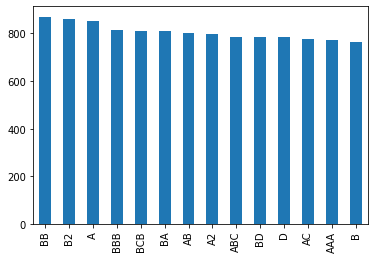

In [ ]:
test["cloud_level"].value_counts().plot.bar()
plt.show()
test["turbine_status"].value_counts().plot.bar()
plt.show()

In [ ]:
print(test["cloud_level"].mode())
print(test["turbine_status"].mode())

In [ ]:
test["cloud_level"].fillna("Low",inplace=True)
test["turbine_status"].fillna("BB",inplace=True)

In [ ]:
sns.heatmap(test.isnull(),yticklabels=False,cbar=False,cmap="viridis")

**Feature Engineering**

In [ ]:
test['datetime']= pd.to_datetime(test['datetime'])
test = pd.get_dummies(data=test,columns=["cloud_level","turbine_status"])
test.head()

In [ ]:
test.dtypes

**Creating a model**

In [ ]:
print(train.shape)
train.head()

(28200, 36)


,tracking_id,datetime,wind_speed(m/s),shaft_temperature(°C),blades_angle(°),gearbox_temperature(°C),engine_temperature(°C),motor_torque(N-m),generator_temperature(°C),atmospheric_pressure(Pascal),area_temperature(°C),windmill_body_temperature(°C),wind_direction(°),resistance(ohm),rotor_torque(N-m),blade_length(m),blade_breadth(m),windmill_height(m),windmill_generated_power(kW/h),cloud_level_Extremely Low,cloud_level_Low,cloud_level_Medium,turbine_status_A,turbine_status_A2,turbine_status_AAA,turbine_status_AB,turbine_status_ABC,turbine_status_AC,turbine_status_B,turbine_status_B2,turbine_status_BA,turbine_status_BB,turbine_status_BBB,turbine_status_BCB,turbine_status_BD,turbine_status_D
0,WM_33725,2019-08-04 14:33:00,94.820023,41.723019,-0.903423,82.410573,42.523015,2563.124522,76.665560,103402.96190,26.897875,20.799761,239.836388,2730.310605,42.084666,2.217542,0.314065,24.281689,6.766521,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0
1,WM_698,2018-11-05 10:13:00,241.832734,-99.000000,-99.000000,44.104919,46.258870,2372.384119,78.129803,17030.90408,39.801469,20.799761,337.944723,1780.207200,107.888643,4.210346,0.448494,27.262139,5.966275,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0
2,WM_39146,2019-09-14 14:03:00,95.484724,41.855473,12.652763,42.322098,42.878552,1657.169646,67.654469,16125.92711,36.116065,45.033197,227.850294,1666.049900,-42.931459,2.719475,0.302321,27.366127,2.874342,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0
3,WM_6757,2018-12-25 15:33:00,238.819424,45.443914,15.115323,44.759643,47.282101,2888.134079,95.389974,18689.73234,46.020045,44.827154,492.081520,1964.502895,42.744596,4.857385,0.367140,24.287767,14.851089,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
4,WM_21521,2019-05-04 03:13:00,10.722890,41.981183,1.715696,-17.616459,43.469852,781.695419,37.423065,114468.16900,34.572941,-99.000000,259.274601,1177.516152,13.387289,2.254034,0.453374,27.971650,3.519074,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
print(test.shape)
test.head()

In [ ]:
test.drop(["atmospheric_temperature(°C)","tracking_id","datetime"],axis=1,inplace=True)

In [ ]:
x = train.drop(["windmill_generated_power(kW/h)","tracking_id","datetime"],axis=1)
y = train["windmill_generated_power(kW/h)"]

In [ ]:
from sklearn.model_selection import train_test_split

In [ ]:
xtrain,xtest,ytrain,ytest = train_test_split(x,y,test_size=0.2)

In [ ]:
xgb = XGBRegressor()
xgb.fit(xtrain,ytrain)
y_train_pred = xgb.predict(xtrain)
y_test_pred = xgb.predict(xtest)
print(r2_score(ytrain,y_train_pred))
print(r2_score(ytest,y_test_pred))

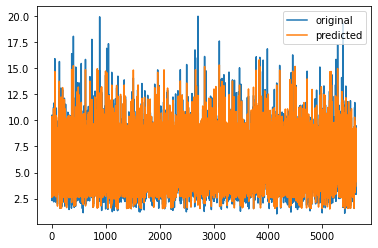

In [ ]:
length = range(len(ytest))
plt.plot(length,ytest,label="original")
plt.plot(length,y_test_pred,label="predicted")
plt.legend()
plt.show()

In [ ]:
pred = xgb.predict(test) # Predicting for the test dataset

In [ ]:
pred